In [1]:
import requests
import pandas as pd
response = requests.get("https://n8n.coinverge.com.br/webhook/dados")
df = pd.DataFrame(response.json())
df['datahora_fechamento'] = pd.to_datetime(df['datahora_fechamento']).dt.tz_localize(None)
df.head(1).T

,0
id,289070
simbolo,ADAUSDT
ultimo_preco,0.82060000
preco_maximo,0.83800000
preco_minimo,0.80540000
preco_abertura,0.82920000
datahora_fechamento,2025-08-31 14:00:06
variacao_preco_percentual,-1.03700000
cenario,+--
variacao_futura_de_preco_positiva,0.012186


In [2]:
import requests
import pandas as pd
import plotly.express as px
import math
import matplotlib.pyplot as plt

# 1) Carregar dados
response = requests.get("https://n8n.coinverge.com.br/webhook/dados", timeout=30)
response.raise_for_status()
df = pd.DataFrame(response.json())

# 2) Preparar colunas de tempo
df['datahora_fechamento'] = pd.to_datetime(df['datahora_fechamento']).dt.tz_localize(None)
df['data'] = df['datahora_fechamento'].dt.floor('D')  # ou .dt.normalize()

# 3) Garantir tipo numérico e remover NaN na métrica alvo
df['variacao_futura_de_preco'] = pd.to_numeric(df['variacao_futura_de_preco'], errors='coerce')
df_med = (
    df.dropna(subset=['variacao_futura_de_preco'])
      .groupby(['simbolo', 'data', 'cenario'], as_index=False)['variacao_futura_de_preco']
      .median()
      .rename(columns={'variacao_futura_de_preco': 'mediana'})
      .sort_values(['simbolo', 'data', 'cenario'])
)


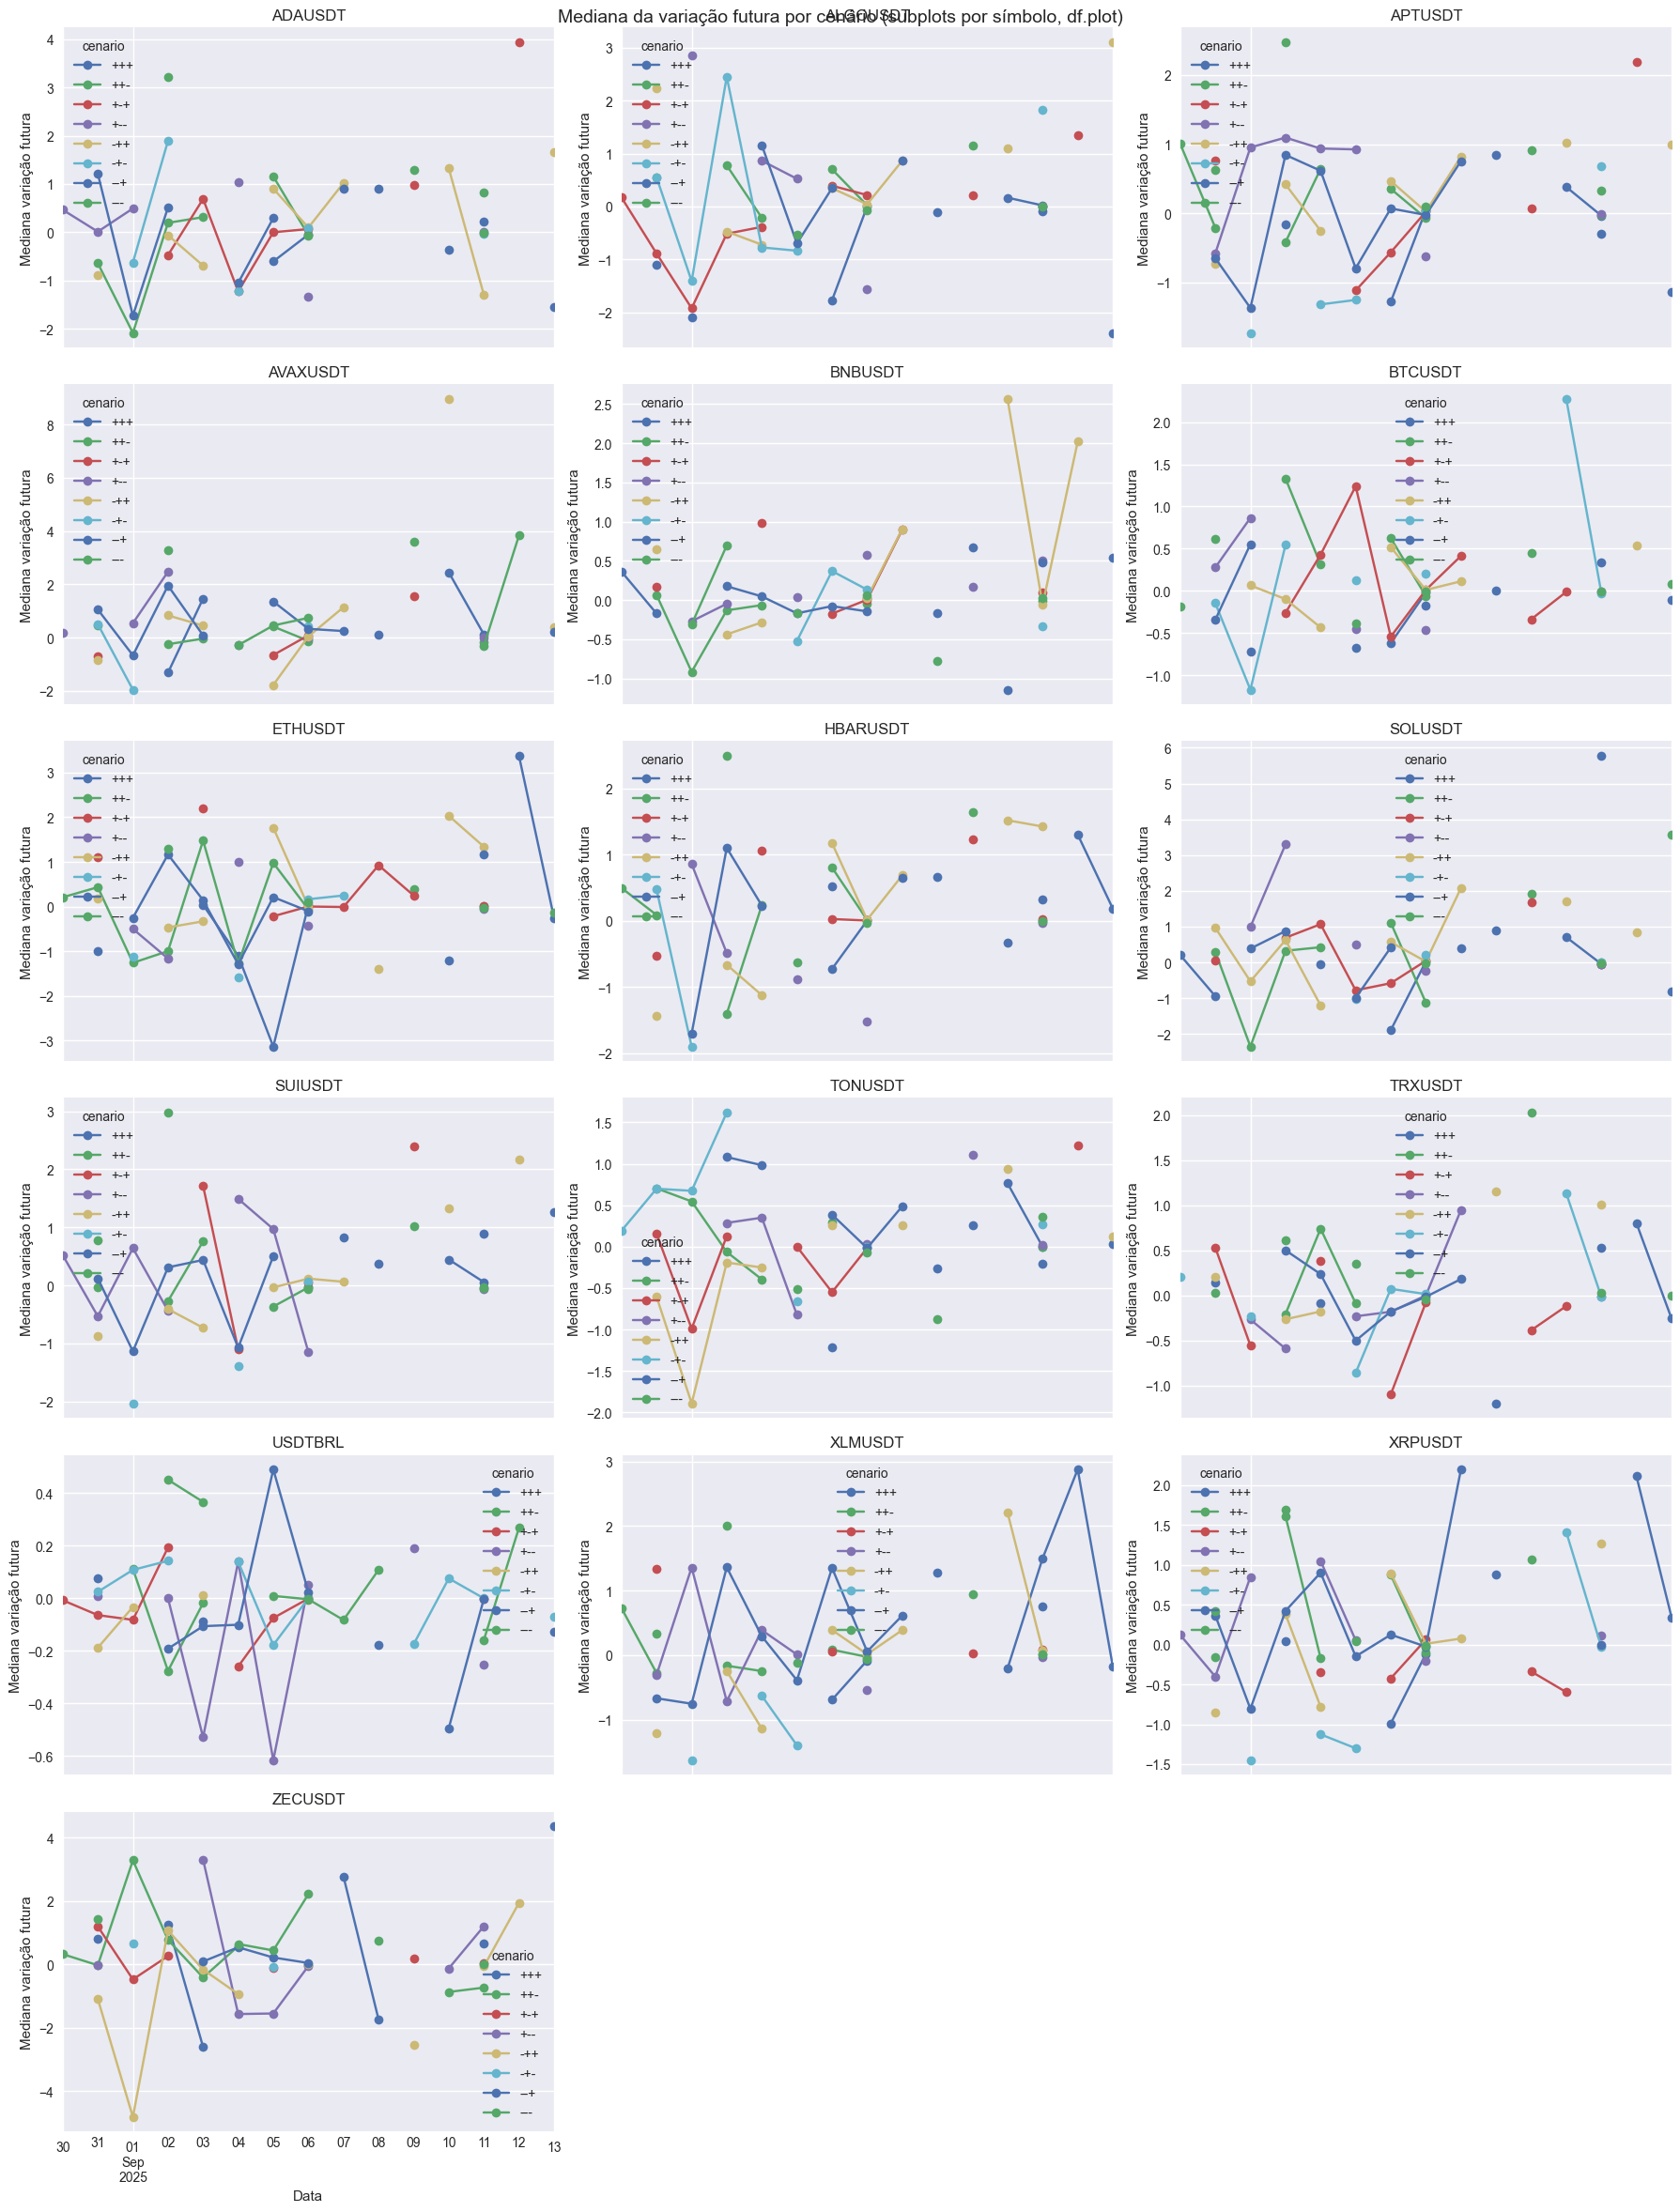

In [3]:
# 5) Plot: um subplot por símbolo, linhas por cenário via df.plot()
simbolos = sorted(df_med['simbolo'].unique())
n = len(simbolos)
cols = 3  # ajuste conforme necessidade
rows = math.ceil(n / cols)

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), sharex=True, sharey=False, squeeze=False)

for i, sym in enumerate(simbolos):
    r, c = divmod(i, cols)
    ax = axes[r, c]

    # Pivot: index=data (ordenado), columns=cenario, values=mediana
    piv = (df_med[df_med['simbolo'] == sym]
           .pivot_table(index='data', columns='cenario', values='mediana', aggfunc='mean')
           .sort_index())

    # Plot com df.plot (usa index no eixo X)
    piv.plot(ax=ax, marker='o')
    ax.set_title(sym)
    ax.set_xlabel('Data')
    ax.set_ylabel('Mediana variação futura')

# Ocultar eixos não usados, se houver
total = rows * cols
for j in range(n, total):
    r, c = divmod(j, cols)
    axes[r, c].set_visible(False)

fig.suptitle('Mediana da variação futura por cenário (subplots por símbolo, df.plot)', fontsize=14)
fig.tight_layout()
plt.show()

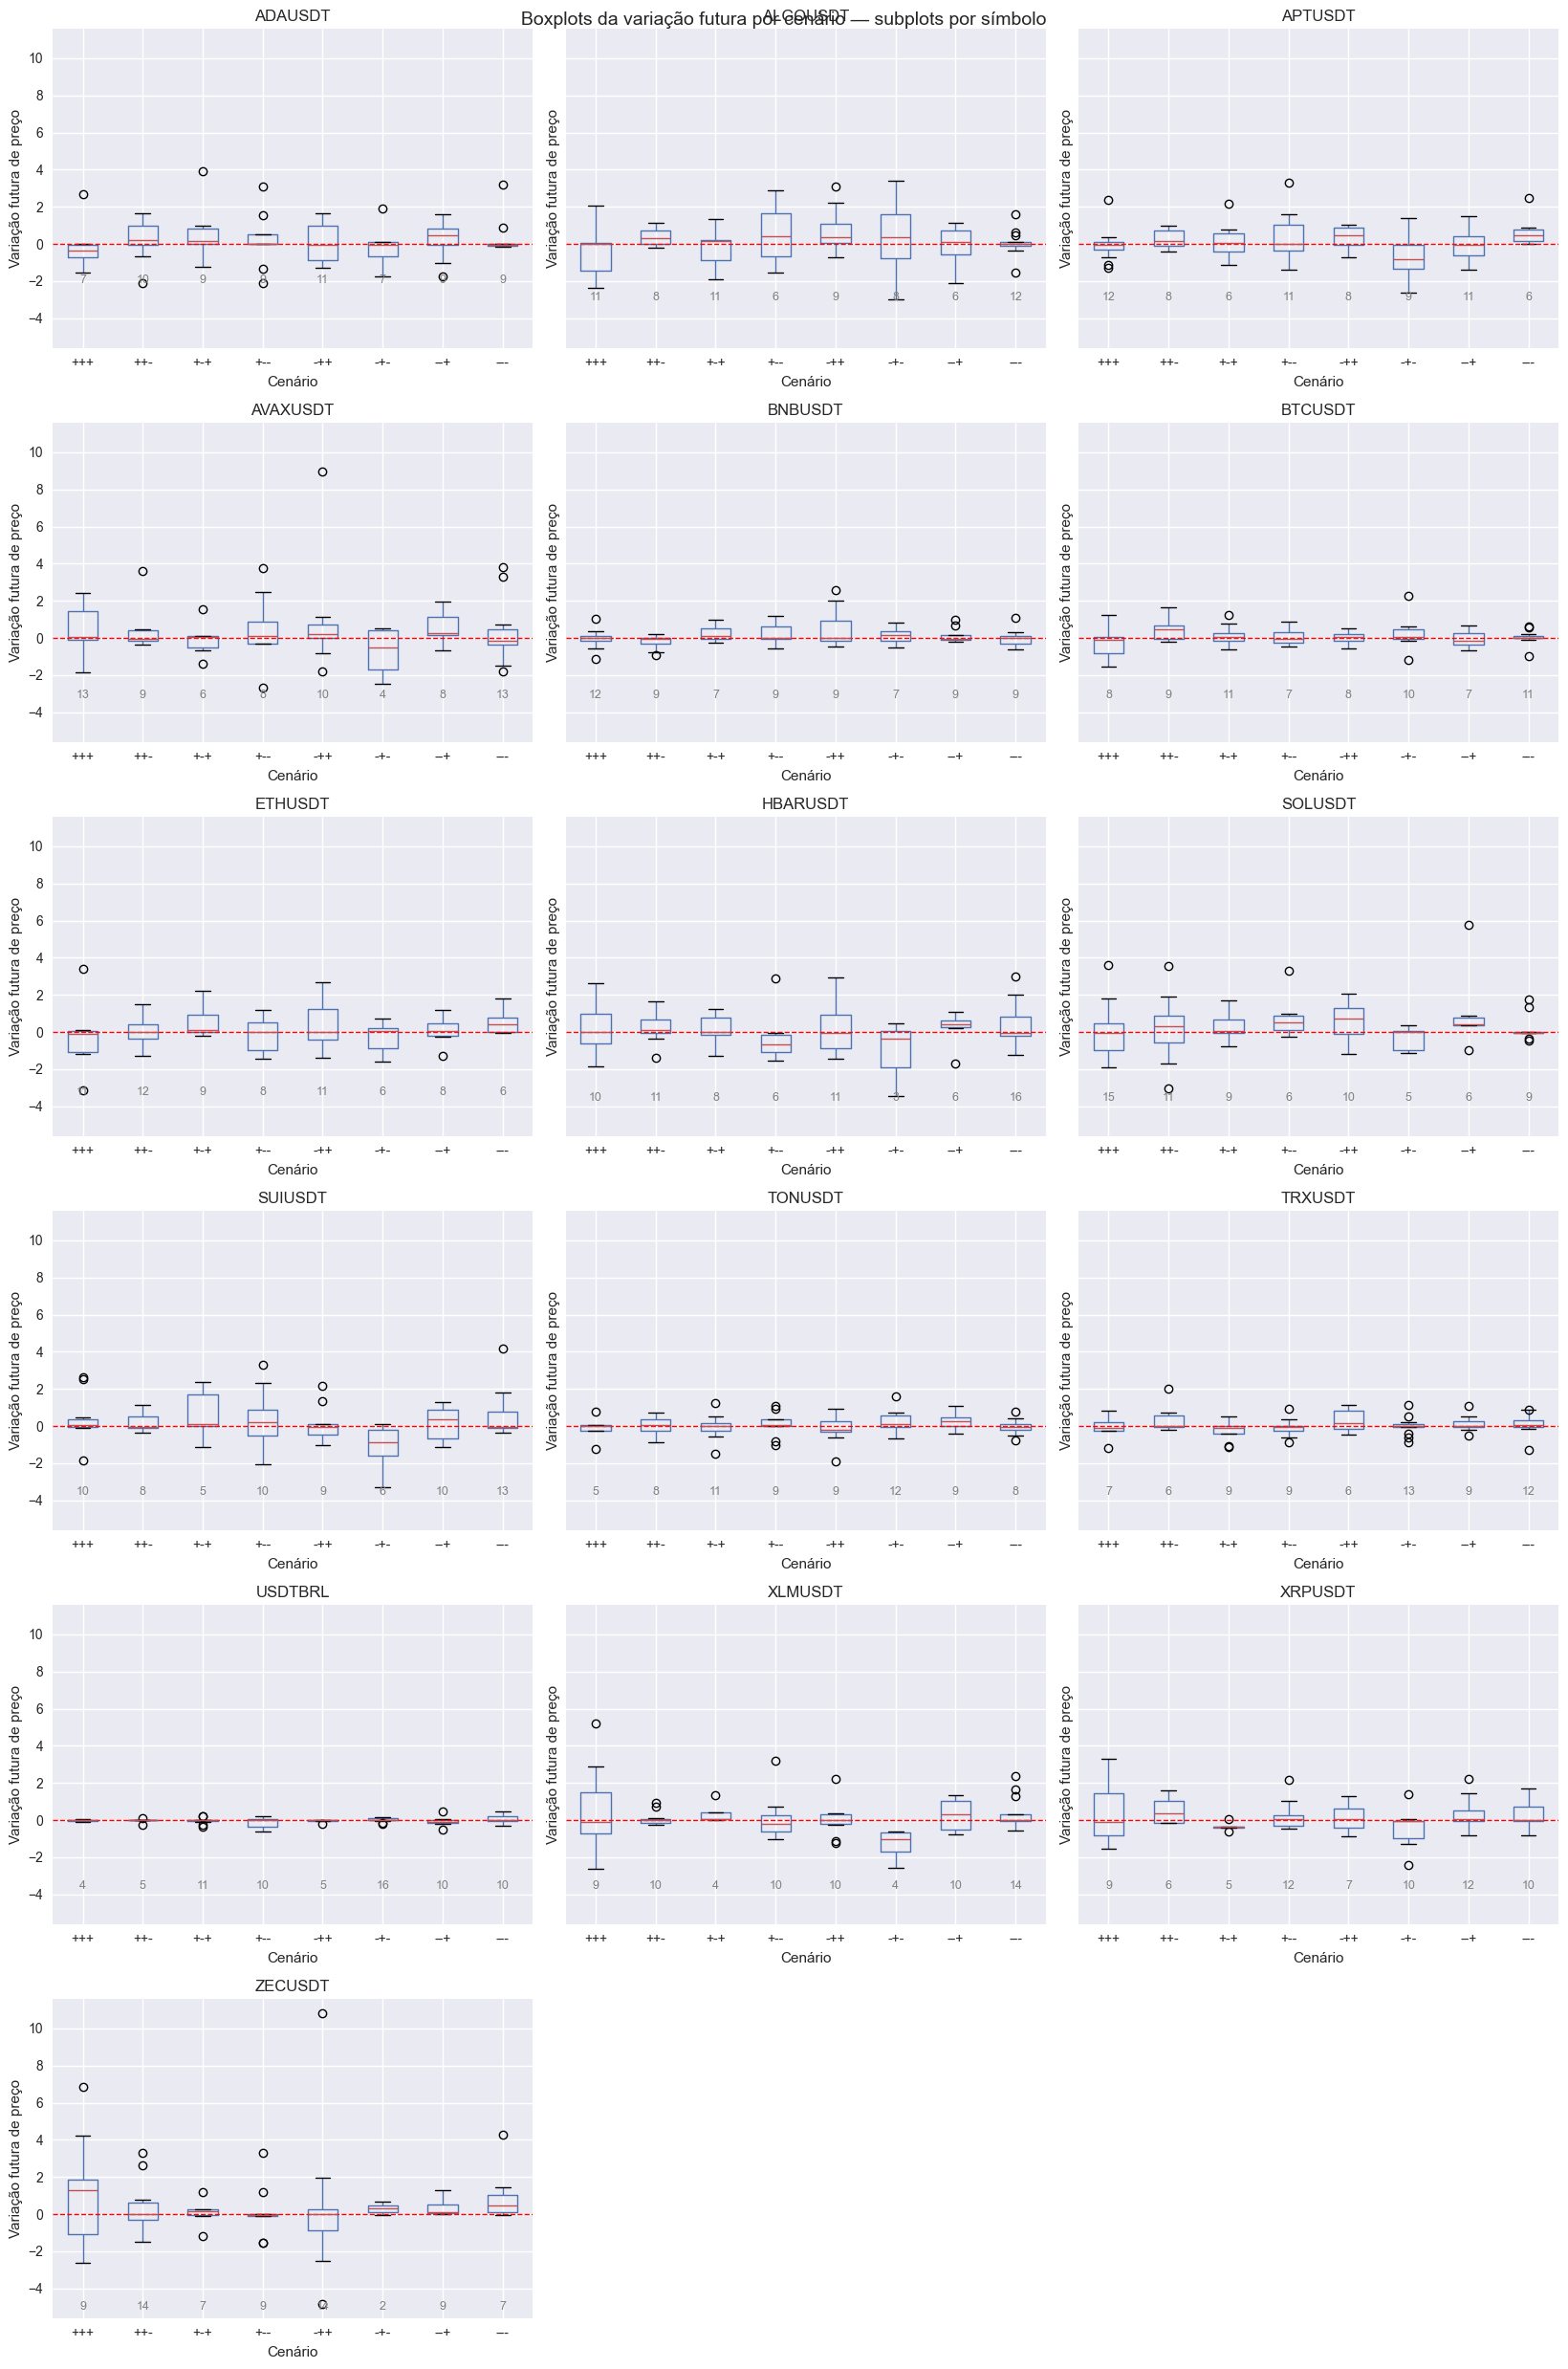

In [4]:
df = df.dropna(subset=['simbolo', 'cenario', 'variacao_futura_de_preco'])

# Ordem consistente dos cenários (ajuste conforme necessário)
cenario_order = sorted(df['cenario'].unique().tolist())
df['cenario'] = pd.Categorical(df['cenario'], categories=cenario_order, ordered=True)

# 3) Subplots: um por símbolo
simbolos = sorted(df['simbolo'].unique().tolist())
n = len(simbolos)
cols = 3 if n > 2 else n
rows = math.ceil(n / cols)

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(rows, cols, figsize=(cols*5.5, rows*4.2), sharey=True, squeeze=False)

for i, sym in enumerate(simbolos):
    r, c = divmod(i, cols)
    ax = axes[r, c]

    df_sym = df[df['simbolo'] == sym]
    # Boxplot: eixo x = 'cenario', eixo y = 'variacao_futura_de_preco'
    df_sym.boxplot(
        column='variacao_futura_de_preco',
        by='cenario',
        ax=ax,
        grid=True,
        rot=0,
        showfliers=True  # opcional: False para ocultar outliers
    )

    # O boxplot do pandas retorna um dicionário com os elementos plotados
    # Precisamos iterar sobre os eixos do boxplot para obter as contagens
    # Cada "caixa" do boxplot corresponde a um cenário
    for j, cenario in enumerate(cenario_order): # Usando cenario_order para garantir a ordem correta
        # Filtrar os dados para o cenário atual
        data_cenario = df_sym[df_sym['cenario'] == cenario]['variacao_futura_de_preco']
        count = len(data_cenario)

        # Encontrar a posição x correta para o texto.
        # As posições x para os cenários são tipicamente 1, 2, 3, ...
        # O boxplot do pandas pode ter um leve deslocamento, mas geralmente é 1-indexado para os grupos.
        # Vamos assumir que a posição x do j-ésimo cenário é j + 1.
        x_position = j + 1

        # Adicionar o texto com a contagem
        ax.text(x_position, ax.get_ylim()[0] * 0.95, str(count),
                ha='center', va='bottom', fontsize=9, color='gray') # Ajuste a posição e estilo conforme necessário

    ax.set_title(sym)
    ax.set_xlabel('Cenário')
    ax.set_ylabel('Variação futura de preço')
    # Adiciona a linha horizontal vermelha no zero
    ax.axhline(0, color='red', linestyle='--', linewidth=1) # linewidth é a espessura da linha

# Ocultar eixos vazios se grid > n
total = rows * cols
for j in range(n, total):
    r, c = divmod(j, cols)
    axes[r, c].set_visible(False)

# Remover o suptitle automático do pandas e definir um título geral
plt.suptitle('')
fig.suptitle('Boxplots da variação futura por cenário — subplots por símbolo', fontsize=14)
fig.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Seus dados (assumindo que df já está carregado e limpo como no seu exemplo)
# df = ...

df = df.dropna(subset=['simbolo', 'cenario', 'variacao_futura_de_preco'])

# Ordem consistente dos cenários (ajuste conforme necessário)
cenario_order = sorted(df['cenario'].unique().tolist())
df['cenario'] = pd.Categorical(df['cenario'], categories=cenario_order, ordered=True)

simbolos = sorted(df['simbolo'].unique().tolist())

# Dicionário para armazenar os resultados dos testes de Kruskal-Wallis
kruskal_results = {}

# Iterar sobre cada símbolo
for sym in simbolos:
    df_sym = df[df['simbolo'] == sym].copy() # Usar .copy() para evitar SettingWithCopyWarning
    
    # Criar uma lista de arrays, onde cada array contém os valores de 'variacao_futura_de_preco' para um cenário específico
    # Isso é necessário para a função kruskal
    data_for_kruskal = []
    cenarios_presentes = df_sym['cenario'].unique() # Obter cenários presentes para este símbolo
    
    for cenario in cenario_order: # Iterar pela ordem desejada
        if cenario in cenarios_presentes:
            data_cenario = df_sym[df_sym['cenario'] == cenario]['variacao_futura_de_preco'].values
            if len(data_cenario) > 0: # Garantir que há dados para o cenário
                data_for_kruskal.append(data_cenario)
        
    # Realizar o teste de Kruskal-Wallis se houver pelo menos 3 grupos (cenários) com dados
    if len(data_for_kruskal) >= 2: # Kruskal-Wallis compara 2 ou mais grupos. Se forem exatamente 2, um teste U de Mann-Whitney seria mais apropriado, mas Kruskal-Wallis também funciona.
        statistic, p_value = kruskal(*data_for_kruskal)
        
        # Armazenar os resultados
        kruskal_results[sym] = {
            'statistic': statistic,
            'p_value': p_value,
            'significant': p_value < 0.05 # Assumindo um nível de significância de 0.05
        }
    else:
        kruskal_results[sym] = {
            'statistic': np.nan,
            'p_value': np.nan,
            'significant': False
        }

# Converter os resultados para um DataFrame para melhor visualização
kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient='index').sort_values('statistic')
kruskal_df.index.name = 'Simbolo'

print("\nTabela de Estatísticas do Teste de Kruskal-Wallis por Símbolo:")
print(kruskal_df)


Tabela de Estatísticas do Teste de Kruskal-Wallis por Símbolo:
          statistic   p_value  significant
Simbolo                                   
AVAXUSDT   3.642909  0.819865        False
ADAUSDT    3.695191  0.814139        False
USDTBRL    3.926393  0.788215        False
HBARUSDT   4.138590  0.763683        False
BNBUSDT    4.228044  0.753168        False
TRXUSDT    4.293708  0.745395        False
TONUSDT    4.448085  0.726959        False
ETHUSDT    5.627063  0.583905        False
BTCUSDT    5.808937  0.562228        False
SUIUSDT    5.953684  0.545168        False
SOLUSDT    6.025058  0.536827        False
ALGOUSDT   6.534165  0.478936        False
XRPUSDT    6.925350  0.436694        False
ZECUSDT    7.785017  0.351932        False
APTUSDT    9.984530  0.189452        False
XLMUSDT   10.614331  0.156349        False
